(sec:BayesianLinearRegression)=
# Bayesian Linear Regression (BLR)

```{epigraph}
> “La théorie des probabilités n'est que le bon sens réduit au calcul” 

(trans.) Probability theory is nothing but common sense reduced to calculation.

-- Pierre Simon de Laplace
```

In this chapter we use Bayes' theorem to infer a (posterior) probability density function for parameters of a *linear statistical model*, conditional on data $\data$. 
This is called Bayesian linear regression (BLR).
In this context "linear" means that the parameters we seek to infer appear in the model only to the first power (specific examples below).
You may already be familiar with ordinary (frequentist) linear regression, such as making a least-squares fit of a polynomial to data; later in this chapter we will show how this is related to BLR.

The advantages of doing *Bayesian* instead of frequentist linear regression are many. The Bayesian approach yields a probability distribution for the unknown parameters and for future model predictions. It also enables us to make all assumptions explicit whereas the frequentist approach puts nearly all emphasis on the collected data. These assumptions can be more general as well; e.g., they allow you to specify prior beliefs on the parameters (such as slope and intercept for a straight line model). Finally, we can do straightforward model checking and add a discrepancy model to account for limitations of the linear model being considered. 

We will use BLR to exemplify the general Bayesian workflow we have summarized in {numref}`sec:Intro:Workflow` and {numref}`sec:BayesianWorkflow`.
To do so, we first need to more precisely define what we mean by linear models.


## Background on linear models

### Definition and examples

In **linear modeling** the dependence on the model parameters $\parsLR$ is **linear**, and this fact will make it possible, for certain priors, to find the distribution of model parameters analytically. Note that we will mostly operate with models depending on more than one parameter. Hence, we denote the model parameters ($\parsLR$) using a bold symbol. (We reserve the generic symbol $\pars$ to include not only $\parsLR$ but also any other parameters specifying our statistical model.) In this chapter we will, however, consider models ($\modeloutput$) that relate a single dependent variable ($\output$) with a single independent one ($\inputt$).

The linear parameter dependence implies that our model $\model{\parsLR}{\inputt}$ separates into a sum of parameters times basis functions. Assuming $N_p$ different basis functions we have

$$
\model{\parsLR}{\inputt} = \sum_{j=0}^{N_p-1} \paraLR_j f_j(\inputt).
$$ (eq_linear_model_b)

Note that there is no $\parsLR$-dependence in the basis functions $f_j(\inputt)$.

From a machine-learning perspective the different basis functions are known as **features**.


```{prf:example} Polynomial basis functions
:label: example:polynomial-linear-model_b

A common linear model corresponds to the use of polynomial basis functions $f_j(x) = x^j$. A polynomial model of degree $N_p-1$ would then be written

$$
M(\parsLR;\inputt) = \sum_{j=0}^{N_p-1} \paraLR_j \inputt^j.
$$ (eq:BayesianLinearRegression:polynomial_basis_b)

Note that the $j=0$ basis function is $f_0(x) = x^0 = 1$ such that the $\paraLR_0$ parameter becomes the $x=0$ intercept.
```

```{prf:example} Liquid-drop model for nuclear binding energies
:label: example:LinearModels:liquid-drop-model_b

The liquid drop model is useful for a phenomenological description of nuclear binding energies (BE) as a function of the mass number $A$ and the number of protons $Z$, neutrons $N$:

\begin{equation}
\text{BE}(A,N,Z) = a_0+a_1A+a_2A^{2/3}+a_3 Z^2 A^{-1/3}+a_4 (N-Z)^2 A^{-1}.
\end{equation}

We have five features: the intercept (constant term, bias), the $A$ dependent volume term, the $A^{2/3}$ surface term and the Coulomb $Z^2 A^{-1/3}$ and pairing $(N-Z)^2 A^{-1}$ terms. Although the features are somewhat complicated functions of the independent variables $A,N,Z$, we note that the $p=5$ regression parameters $\parsLR = (a_0, a_1, a_2, a_3, a_4)$ enter linearly. 
```

<!--
Font awesome test: <i class="fas fa-pencil-alt"></i> Did it work?
-->

::::{admonition} Checkpoint question
:class: my-checkpoint
Is a Fourier series expansion of a function a linear model?
:::{admonition} Hint
:class: dropdown, my-hint 
If $f(x)$ is an odd function with period $2L$, a 
Fourier sine expansion of $f(x)$ with $N$ terms takes the form

$$
   f(x)= \sum_{n=1}^N b_n \sin(\frac{n \pi x}{L}),  
$$

where the $b_n$ are to be determined.

:::
:::{admonition} Answer
:class: dropdown, my-answer
The parameters $b_n$ appear linearly, so this is a linear model *if* only the parameters are being determined (i.e. $L$ and $N$ are given).
Note that with finite $N$ this model will not be a perfect reproduction of a general $f(x)$, so there will be a *discrepancy*.
:::
::::


::::{admonition} Checkpoint question
:class: my-checkpoint
Which of the following are linear models and which are nonlinear?

$$
\begin{align}
  (a)\quad  & f(x) = \beta_0 + \beta_1 \sqrt{x}  \quad \text{with } \parsLR = (\beta_0, \beta_1)\\
  (b)\quad  & E(N) = E_\infty + a e^{-b N} \quad \text{with } \parsLR = (E_\infty, a, b) \\
  (c)\quad  & g(z) = a e^{-z} + b e^{-2z} + c e^{-3z} \quad \text{with } \parsLR = (a, b, c)
\end{align}
$$
:::{admonition} Hint
:class: dropdown, my-hint 
Remember that it is the *parameter* dependence that dictates whether it is linear.
:::
:::{admonition} Answer
:class: dropdown, my-answer
The first and third are linear, the second is not (because of the $b$ parameter).
::::


### Converting linear models to matrix form

When using a linear model we have access to a set of data $\mathcal{D}$ for the dependent variable, e.g., the $N_d$ values 

\begin{equation}
\data = [y_1, y_2,\dots, y_{N_d}]^T.
\end{equation}

For each datum $y_i$ there is an independent variable $x_i$, and our model for the $i^{\text{th}}$ datum  is

\begin{equation}
M_i \equiv M(\parsLR;x_i) = \sum_{j=0}^{N_p-1} \paraLR_j f_j(x_i).
\end{equation}

We can collect the basis functions evaluated at each independent variable $x_i$ in a matrix $\mathbf{X}$ of dimension $N_d \times N_p$:

$$
\dmat = 
  \begin{bmatrix} 
        f_0(x_1) & \ldots & f_{N_p-1}(x_1) \\
        f_0(x_2) & \ldots & f_{N_p-1}(x_2) \\
        \vdots  & \ddots & \vdots \\
        f_0(x_{N_d}) & \ldots & f_{N_p-1}(x_{N_d})
    \end{bmatrix}
$$ (eq:BayesianLinearRegression:design-matrix_b)

This matrix will be referred to as a **design matrix**. 

```{prf:example} The design matrix for polynomial models
:label: example:design-matrix-polynomial-models_b

The design matrix for a linear model with polynomial basis functions becomes

\begin{equation}
\dmat =
\begin{bmatrix} 
1 & x_{1}^1 & x_{1}^2 & \dots & x_{1}^{p-1} \\
1 & x_{2}^1 & x_{2}^2 & \dots & x_{2}^{p-1} \\
1 & x_{3}^1 & x_{3}^2 & \dots & x_{3}^{p-1} \\                      
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_{N_d}^1 & x_{N_d}^2 & \dots & x_{N_d}^{p-1} \\
\end{bmatrix}, 
\end{equation}

where we are considering a polynomial of degree $p-1$, which implies a model with $p$ features (including the intercept). It is also known in linear algebra circles as a [Vandermonde matrix](https://en.wikipedia.org/wiki/Vandermonde_matrix).
```

::::{admonition} Checkpoint question
:class: my-checkpoint
What is the design matrix for a Fourier cosine series expansion with $N_p$ terms (plus a constant)?
:::{admonition} Hint
:class: dropdown, my-hint

If $f(x)$ is an even function with period $2L$, a 
Fourier cosine expansion of $f(x)$ with $N_p$ terms (plus a constant) takes the form

$$
   f(x)= \frac{a_0}{2} + \sum_{n=1}^{N_p} a_n \cos(\frac{n \pi x}{L}),  
$$

where the $a_n$ are to be determined.


:::
:::{admonition} Answer
:class: dropdown, my-answer
For convenience, let $\omega = \pi/L$. Then the design matrix is: 

\begin{equation}
\begin{bmatrix}
1 & \cos(\omega x_1) & \cos(2\omega x_1) & \dots  & \cos(N_p \omega x_1) \\
1 & \cos(\omega x_2) & \cos(2\omega x_2) & \dots  & \cos(N_p \omega x_2) \\
1 & \cos(\omega x_3) & \cos(2\omega x_3) & \dots  & \cos(N_p \omega x_3) \\
\vdots &  \vdots & \vdots & \ddots & \vdots\\
1 & \cos(\omega x_{N_d}) & \cos(2\omega x_{N_d})  & \dots & \cos(N_p \omega x_{N_d}) \\
\end{bmatrix}
\end{equation}
::::




Next, using the column vector $\parsLR$ for the parameters, 

\begin{equation}
\parsLR = [\paraLR_0,\paraLR_1, \paraLR_2,\dots, \paraLR_{N_p-1}]^T,
\end{equation}

we can write the general (additive) statistical model

$$
\data = M(\parsLR) + \delta \data + \delta M.
$$ (eq:BayesianLinearRegression:eq_StatModel)

with $M(\parsLR) \rightarrow M(\parsLR; \inputt)$ as the matrix equation


$$
   \data = \dmat \parsLR + \residuals.
$$ (eq:BayesianLinearRegression:eq_linear_matrix_eq)

The last term $\residuals$ is a column vector of so-called **residuals**. This term includes both the data uncertainty $\delta\data$ and the model uncertainty $\delta M$, i.e., it expresses the part of the dependent variable, for which we have data, that we cannot describe using a linear model. Formally, we can therefore write $\residual_i = y_i - M_i$ and define the vector $\residuals$ as

\begin{equation}
\residuals = [\residual_1,\residual_2, \residual_3,\dots, \residual_{N_d}]^T.
\end{equation}

It is important to realize that our model $M$ provides an approximate description of the data. For now we will take $\delta M = 0$; that is, we assume that the entire residual is explained by data uncertainty. 
More generally we expect that $\delta M \neq 0$ (this is often summarized as *all models are wrong*) because in a realistic setting we have no guarantee that the data is generated by a linear process. Of course, based on physics insight, or other assumptions, there might exist very good reasons for using a linear model to explain the data (taking into account $\delta\data$).


::::{admonition} Checkpoint question
:class: my-checkpoint
Why does the Fourier series from the last section have to be truncated to a finite number of terms in practice?
:::{admonition} Hint
:class: dropdown, my-hint 
Could I do linear algebra with $N = \infty$?

:::
:::{admonition} Answer
:class: dropdown, my-answer
Our manipulations will be with *finite* matrices, so the basis size must be finite in practice.
::::


### The normal equation

A regression analysis often aims at finding the parameters $\parsLR$ of a model $M$ such that the vector of residuals $\residuals$ is minimized in the sense of its Euclidean norm (or 2-norm). This is assumed in the familiar least-squares analysis. Below we will see that this particular goal arises naturally in Bayesian linear regression. 

Here we will lay the groundwork for an analytical solution to the linear regression problem by  finding the set of parameters $\parsLR^*$ (we will typically use an asterisk to denote specific parameters that are "optimal" in some sense) that minimizes

$$
C(\parsLR)\equiv \sum_{i=1}^{N_d} \residual_i^2 = \sum_{i=1}^{N_d}\left(y_i-M_i\right)^2 = \left\{\left(\data-\dmat \parsLR\right)^T\left(\data-\dmat \parsLR\right)\right\}.
$$ (eq:BayesianLinearRegression:cost-function)

The solution to this optimization problem turns out to be a solution of the normal equation and is known as ordinary least-squares or ordinary linear regression. (Later an exercise will have you generalize this problem to the case where the last factor in Eq. {eq}`eq:BayesianLinearRegression:cost-function` has a covariance matrix between the two terms.)

````{prf:theorem} Ordinary least squares (the normal equation)
:label: theorem:BayesianLinearRegression:normal-equation_b

The ordinary least-squares method corresponds to finding the optimal parameter vector $\parsLR^*$ that minimizes the Euclidean norm of the residual vector $\residuals = \data - \dmat \parsLR$, where $\data$ is a column vector of observations and $\dmat$ is the design matrix {eq}`eq:BayesianLinearRegression:design-matrix_b`. 

Finding this optimum turns out to correspond to solving the **normal equation** 

$$
\dmat^T\data = \dmat^T\dmat\parsLR^*.  
$$ (eq:BayesianLinearRegression:NormalEquation)

Given that the **normal matrix** $\dmat^T\dmat$ is invertible, the solution to the normal equation is given by 

$$
\parsLR^* =\left(\dmat^T\dmat\right)^{-1}\dmat^T\data.
$$ (eq:BayesianLinearRegression:OLS_optimum_b)
````

````{prf:proof}
Due to its quadratic form, the Euclidean norm $\left| \residuals \right|_2^2 = \left(\data-\dmat\parsLR\right)^T\left(\data-\dmat\parsLR\right) \equiv C(\parsLR)$ is bounded from below and we just need to find the single extremum. That is we need to solve the problem

\begin{equation}
\parsLR^* =
{\displaystyle \mathop{\mathrm{arg} \min}_{\parsLR\in
{\mathbb{R}}^{N_p}}} \left(\data-\dmat\parsLR\right)^T\left(\data-\dmat\parsLR\right).
\end{equation}

In practical terms it means we will require

\begin{align}
\frac{\partial C(\parsLR)}{\partial \paraLR_j} = \frac{\partial }{\partial \paraLR_j} \Bigg[  \sum_{i=1}^{N_d}\Big(y_i &-\paraLR_0 f_0(x_i)-\paraLR_1f_1(x_i)-\paraLR_2f_2(x_i)-\dots \\
&-  \paraLR_{N_p-1}f_{N_p-1}(x_i)\Big)^2\Bigg] = 0, 
\end{align}

where $y_i$ and $f_j(x_i)$ are the elements of $\data$ and $\dmat$, respectively. Performing the derivative results in

$$
\frac{\partial C(\parsLR)}{\partial \paraLR_j} = -2\Bigg[ \sum_{i=1}^{N_d}f_j(x_i)\Big(y_i &-\paraLR_0 f_0(x_i)-\para_1f_1(x_i)-\paraLR_2f_2(x_i)-\dots \\
&-\paraLR_{N_p-1}f_{N_p-1}(x_i)\Big)\Bigg]=0,
$$ (eq:BayesianLinearRegressioin:gradient-elements)

which is one element of the full gradient vector. This gradient vector can be succinctly expressed in matrix-vector form as

$$
\boldsymbol{\nabla}_{\pars} C(\parsLR) = -2 \dmat^T\left( \data-\dmat\parsLR\right).  
$$ (eq:BayesianLinearRegression:gradient)

The minimum of $C$, where $\boldsymbol{\nabla}_{\parsLR} C(\parsLR) = 0$, then corresponds to 

$$
\dmat^T\data = \dmat^T\dmat\parsLR^*,  
$$ (eq:BayesianLinearRegression:minimumC)

which is the normal equation. Finally, if the matrix $\dmat^T\dmat$ is invertible then we have the solution

$$
\parsLR^* =\left(\dmat^T\dmat\right)^{-1}\dmat^T\data.
$$ (eq:BayesianLinearRegression:normal_equation_solution)
````

```{admonition} The pseudo-inverse (or Moore-Penrose inverse)
We note that since our design matrix is defined as $\dmat\in
{\mathbb{R}}^{N_d\times N_p}$, the combination $\dmat^T\dmat \in
{\mathbb{R}}^{N_p\times N_p}$ is a square matrix. The product $\left(\dmat^T\dmat\right)^{-1}\dmat^T$ is called the pseudo-inverse of the design matrix $\dmat$. The pseudo-inverse is a generalization of the usual matrix inverse. The former can be defined also for non-square matrices that are not necessarily full rank. In the case of full-rank and square matrices the pseudo-inverse is equal to the usual inverse.
```

::::{admonition} Spot the error!
:class: my-checkpoint
Your classmate simplifies $\dmat^T\data = \dmat^T\dmat\parsLR^*$ as $\data = \dmat\parsLR^*$ and then solves for $\parsLR^*$ as $\parsLR^* = \dmat^{-1}\data$. What is wrong?
:::{admonition} Answer
:class: dropdown, my-answer
$\dmat$ is not a square matrix (in general).
:::
::::

The regression residuals $\residuals^{*} =  \data - \dmat \parsLR^{*}$ can be used to obtain an estimator $s^2$ of the variance of the residuals

$$
s^2 = \frac{(\residuals^*)^T\residuals^*}{N_d-N_p},
$$ (eq:BayesianLinearRegression:EstimatorVariance)

where $N_p$ is the number of parameters in the model and $N_d$ is the number of data.


In frequentist linear regression using the ordinary least-squares method we make a leap of faith and decide that we are seeking a "best" model with an optimal set of parameters $\parsLR^*$ that minimizes the  Euclidean norm of the residual vector $\residuals$, as above. 







## Workflow for Bayesian linear regression



In following the four-step workflow for Bayesian inference (see {numref}`sec:Intro:Workflow`), we need to
1. Identify the observable and unobservable quantities and formulate appropriately informative priors before new data is used.
2. Set up a full statistical model relating the physics model and data, including all errors. We need to consistently build in our knowledge of the underlying physics and of the data measurement process. 
3. Calculate and interpret the relevant posterior distributions.  This is the conditional probability distribution of the unobserved quantities of interest, given the observed data.
4. Do model checking: assess the fit of the model and the reasonableness of the conclusions, testing the sensitivity to model assumptions in steps 1 and 2. From this assessment we modify the model appropriately and repeat all four steps. 


To carry out steps 1. and 2. for BLR, 
we note that our goal is to relate data $\data$ to the output of a linear model expressed in terms of its design matrix $\dmat$ and its model parameters $\parsLR$ by Eq. {eq}`eq:BayesianLinearRegression:eq_StatModel`.
We consider the special case of one dependent response variable ($\output$) and a single independent variable ($\inputt$), for which the data set ($\data$) and the residual vector ($\residuals$) are both $N_d \times 1$ column vectors with $N_d$ the length of the data set. The design matrix ($\dmat$) has dimension $N_d \times N_p$ and the parameter vector ($\parsLR$) is $N_p \times 1$.

For the residuals, consider a statistical model that describes the mismatch between our model and observations as in Eq. {eq}`eq:BayesianLinearRegression:eq_StatModel` (recall that we assume here that $\Delta M = 0$). Knowledge (and/or assumptions) concerning measurement uncertainties, or modeling errors, then allows to describe the residuals as a vector of random variables that are distributed according to a PDF


\begin{equation}
  \residuals \sim \pdf{\residuals}{I},
\end{equation}

where we introduce the relation $\sim$ to indicate how a (random) variable is *distributed*. 
A very common assumption is that errors are normally distributed with zero mean. As before we let $N_d$ denote the number of data points in the (column) vector $\data$. Introducing the $N_d \times N_d$ covariance matrix $\covres$ for the errors we then have the explicit distribution

$$
\pdf{\residuals}{\covres, I} = \mathcal{N}(\zeros,\covres).
$$ (eq:BayesianLinearRegression:ResidualErrors)

Recall that the notation for the multivariate normal distribution $\mathcal{N}$ here is that the mean is $\zeros$ and the covariance matrix is $\covres$.

To carry out step 2. we adapt Bayes' theorem to the current problem

$$
\pdf{\pars}{\data,I} = \frac{\pdf{\data}{\pars,I}\pdf{\pars}{I}}{\pdf{\data}{I}}
  \quad\longrightarrow\quad
  \pdf{\parsLR}{\data, \covres, I} = \frac{\pdf{\data}{\parsLR,\covres,I}\pdf{\parsLR}{I}}{\pdf{\data}{I}} ,
$$ (eq:BayesianLinearRegression:eq_bayes)

which is the conditioned probability of the quantities of interest, namely the model parameters, on the observed measurements with known covariance for the measurement errors. 
In most realistic data analyses we will then have to resort to numerical evaluation or sampling of the posterior. However, certain combinations of likelihoods and priors facilitate analytical derivation of the posterior. In this chapter we will explore one such situation and also demonstrate how we can recover the results from an ordinary least squares approach with certain assumptions. A slightly more general approach involves so called **conjugate priors**. This class of probability distributions have clever functional relationships with corresponding likelihood distributions that facilitate analytical derivation. 

To evaluate this posterior we must have expressions for both factors in the numerator on the right-hand side (following the Bayesian research workflow in {numref}`sec:BayesianWorkflow`): the prior $\pdf{\parsLR}{I}$ and the likelihood $\pdf{\data}{\parsLR,\covres,I}$. Note that the prior does not depend on the data or the error model. The denominator $\pdf{\data}{I}$, sometimes known as the evidence, becomes irrelevant for the task of parameter estimation since it does not depend on $\parsLR$. It is typically quite challenging, if not impossible, to evaluate the evidence for a multivariate inference problem except for some very special cases. In this chapter we will only be dealing with analytically tractable problems and will therefore (in principle) be able to evaluate also the evidence.

::::{admonition} Checkpoint question
:class: my-checkpoint
Why is it possible to perform parameter estimation without computing the evidence? 
:::{admonition} Hint
:class: dropdown, my-hint
In Bayes theorem, the posterior is normalized. Verify this by integrating both sides over the parameters. 
For parameter estimation, do you need the posterior to be normalized (e.g., do you need more than the shape and location of the posterior density)?
:::
::::

::::{admonition} Checkpoint question
:class: my-checkpoint
Can you think of why it is so challenging to compute the evidence? 
:::{admonition} Hint
:class: dropdown, my-hint 
To evaluate the evidence, you need to introduce an integral over all possible values of
$\pars$. Why might this integral harder to do than the likelihood or prior evaluation?
:::
::::


<!--
The Bayesian research workflow in {numref}`sec:BayesianWorkflow` breaks the steps leading to {eq}`eq:BayesianLinearRegression:eq_bayes` 

Having such a statistical model for the errors makes it possible to derive an expression for the data likelihood $\pdf{\data}{\parsLR,\covres,I}$ (see below). Using Bayes' theorem {eq}`eq:BayesTheorem:bayes-theorem-for-data` we can then "invert" this conditional probability distribution and write the parameter posterior
-->


<!--
## Bayes' theorem for the normal linear model
-->


## The prior

First we assign a prior probability $\pdf{\parsLR}{I}$ for the model parameters. In order to facilitate analytical expressions we will explore two options: (i) a very broad, uniform prior, and (ii) a Gaussian prior. For simplicity, we consider both these priors to have zero mean and with all model parameters being i.i.d. 

As discussed earlier, we rarely want to use a truly uniform prior, preferring a wide beta distribution instead. 
We will assume that the width is large enough that it will be effectively flat where our Bayesian linear regression likelihood is not negligible.
Then for the analytic calculations here we can take the uniform prior for the $N_p$ parameters to be

$$
\pdf{\parsLR}{I} = \frac{1}{(\Delta\paraLR)^{N_p}} \left\{ 
\begin{array}{ll}
1 & \text{if all } \paraLR_i \in [-\Delta\paraLR/2, +\Delta\paraLR/2] \\
0 & \text{else},
\end{array}
\right.
$$ (eq:BayesianLinearRegression:uniform_iid_prior)

with $\Delta\paraLR$ the width of the prior range in all parameter directions (this assumes we have standardized the data so that it has roughly the same extent in all directions). 

The Gaussian prior that we will also be exploring is

$$
\pdf{\parsLR}{I} = \left(\frac{1}{2\pi\sigma_\paraLR^2}\right)^{N_p/2} \exp\left[ -\frac{1}{2}\frac{\parsLR^T\parsLR}{\sigma_\paraLR^2} \right],
$$ (eq:BayesianLinearRegression:gaussian_iid_prior)

with $\sigma_\paraLR$ the standard deviation of the prior for all parameters.

::::{admonition} Checkpoint question
:class: my-checkpoint
Are these priors normalized?
:::{admonition} Hint-1
:class: dropdown, my-hint 
Integrate both sides over $\parsLR$ to check normalization, remembering that $\parsLR$ is a vector, so this is a multidimensional integral.
:::
:::{admonition} Hint-2
:class: dropdown, my-hint 
Both normalization integrals in this case can be *factorized* into the product of one-dimensional integrals. This is true here for the Gaussian prior because the covariance matrix is taken to be diagonal.
:::
:::{admonition} Answer
:class: dropdown, my-answer
Yes, they are normalized.
:::
::::


::::{admonition} Checkpoint question
:class: my-checkpoint
In what limit are the uniform and Gaussian priors (as defined here) effectively equivalent?
:::{admonition} Answer
:class: dropdown, my-answer
The limit where $\Delta\paraLR/2$ and $\sigma_\paraLR$ are both so large that the priors are effectively flat where the likelihood is not negligible.
:::
::::



::::{admonition} Checkpoint question
:class: my-checkpoint
What is implied (i.e., what are you assuming) if you use a truly uniform prior for model parameters?
:::{admonition} Hint
:class: dropdown, my-hint 
Is it possible that the parameters could be arbitrarily large?
:::
::::




## The likelihood

Assuming normally distributed residuals, as we have done, it turns out to be straightforward to express the data likelihood. In the following we will make the further assumption that errors are *independent*. This implies that the covariance matrix $\covres$ is diagonal and given by a vector $\sigmas$,

$$
\covres &= \mathrm{diag}(\sigmas^2), \, \text{where} \\ 
\sigmas^2 &= \left( \sigma_0^2, \sigma_1^2, \ldots, \sigma_{N_d-1}^2\right),
$$ (eq:BayesianLinearRegression:independent_errors)

and $\sigmai^2$ is the variance for residual $\residual_i$. 

Let's first consider a single datum $\data_i$ and the corresponding model prediction $M_i = \left( \dmat \parsLR \right)_i$. We are interested in the likelihood for this single data point

\begin{equation}
\pdf{\data_i}{\parsLR,\sigmai^2,I}.
\end{equation}

Since the relation between data and residual is a simple additive transformation $\data_i = \modeloutput_i + \residual_i$,
we can use the standard probability rules to obtain (alternatively we can apply the recipe for changing variables *(add reference)*) 

$$
\begin{align}
\pdf{\data_i}{\parsLR,\sigmai^2,I} &= \int d\residual_i\, \pdf{\data_i, \residual_i}{\parsLR,\sigmai^2,I} \\
  &= \int d\residual_i\, \pdf{\data_i}{\residual_i, \parsLR, I}\, \pdf{\residual_i}{\sigmai^2} \\
  &= \int d\residual_i\, \delta\bigl(\data_i - (\modeloutput_i + \residual_i)\bigr)
     \frac{1}{\sqrt{2\pi}\sigmai} e^{-\residual_i^2/2\sigmai^2} \\
&= \frac{1}{\sqrt{2\pi}\sigmai} \exp \left[ -\frac{(\data_i - \modeloutput_i)^2}{2\sigmai^2} \right]
\end{align}
$$ (eq:BayesianLinearRegression:likelihood_eq_1)

where we used that $\residual_i \sim \mathcal{N}(0,\sigmai^2)$. Note that the parameter dependence sits in $\modeloutput_i \equiv \modeloutput(\parsLR, \inputs_i)$.

::::{admonition} Checkpoint question
:class: my-checkpoint
Fill in the details for the steps in {eq}`eq:BayesianLinearRegression:likelihood_eq_1`.
:::{admonition} Hint
:class: dropdown, my-hint 
Review the probability rules in {numref}`Chapter %s <ch:Inferenceandpdfs>`. The first step integrates in $\residual_i$.
:::
:::{admonition} Answer
:class: dropdown, my-answer
1. Apply the sum rule to integrate in $\residual_i$.
1. Apply the product rule, taking into account that $\residual_i$ depends only on $\sigmai$.
1. Use $\data_i = \modeloutput_i + \residual_i$ to evaluate the first pdf; it is a $\delta$ function because $\data_i$ is exactly specified given $\modeloutput_i \equiv \modeloutput(\parsLR, \inputs_i)$ and $\epsilon_i$.
1. Evaluate the integral using the $\delta$ function and $\delta\bigl(\data_i - (\modeloutput_i + \residual_i)\bigr) = \delta\bigl(\epsilon_i - (\data_i - \modeloutput_i)\bigr)$.
:::
::::







Furthermore, since we assume that the residuals are independent we find that the total likelihood becomes a product of the individual ones for each element of $\data$:

$$
\pdf{\data}{\parsLR,\sigmas^2,I} &= \prod_{i=0}^{N_d-1} \pdf{\data_i}{\parsLR,\sigmai^2,I} \\
&= \left(\frac{1}{2\pi}\right)^{N_d/2} \frac{1}{\left| \covres \right|^{1/2}} \exp\left[ -\frac{1}{2} (\data - \dmat \parsLR)^T \covres^{-1} (\data - \dmat \parsLR) \right],
$$ (eq:BayesianLinearRegression:normal_likelihood)

where we note that the diagonal form of $\covres$ implies that $\left| \covres \right|^{1/2} = \prod_{i=0}^{N_d-1} \sigmai$ and that the exponent becomes a sum of squared and weighted residual terms

$$
-\frac{1}{2} (\data - \dmat \parsLR)^T \covres^{-1} (\data - \dmat \parsLR) = -\frac{1}{2} \sum_{i=0}^{N_d - 1} \frac{(\data_i - (\dmat \parsLR)_i)^2}{\sigma_i^2}.
$$ (eq:BayesianLinearRegression:LR_likelihood_exponent)

In the special case that all residuals are both *independent and identically distributed* (i.i.d.) we have that all variances are the same, $\sigmai^2 = \sigmares^2$, and the full covariance matrix is completely specified by a single parameter $\sigmares^2$. For this special case, the likelihood becomes

$$
\pdf{\data}{\parsLR,\sigmares^2,I} = \left(\frac{1}{2\pi\sigmares^2}\right)^{N_d/2} \exp\left[ -\frac{1}{2\sigmares^2} \sum_{i=0}^{N_d - 1} (\data_i - (\dmat \parsLR)_i)^2 \right].
$$ (eq:BayesianLinearRegression:normal_iid_likelihood)

```{caution} 
For computational performance it is always better (if possible) to write sums, such as the one in the exponent of {eq}`eq:BayesianLinearRegression:normal_iid_likelihood`, in the form of vector-matrix operations rather than as for-loops. This particular sum should therefore be implemented as $(\data - \dmat \parsLR)^T (\data - \dmat \parsLR)$ to employ powerful optimization for vectorized operations in existing numerical libraries (such as [`numpy`](https://numpy.org/) in `python` and [`gsl`](https://www.gnu.org/software/gsl/), [`mkl`](https://www.intel.com/content/www/us/en/developer/tools/oneapi/onemkl.html) for C and other compiled programming languages).
```

```{admonition} Two views on the likelihood
Since observed data is generated stochastically, through an underlying $\text{``data-generating process''}$, it is appropriately described by a probabibility distribution. This is the $\text{``data likelihood''}$ that describes the probability distribution for observed data given a specific data-generating process (as indicated by the information on the right-hand side of the conditional). 

- View 1: Assuming fixed values of $\parsLR$; what are long-term frequencies of future data observations as described by the likelihood? 
- View 2: Focusing on the data $\data_\mathrm{obs}$ that we have; how does the likelihood for this data set depend on the values of the model parameters?

This second view is the one that we will be adopting when allowing model parameters to be associated with probability distributions. The likelihood still describes the probability for observing a set of data, but we emphasize its parameter dependence by writing

\begin{equation}
\pdf{\data}{\parsLR,\sigma^2,I} = \mathcal{L}(\parsLR).
\end{equation}

This function is **not** a probability distribution for model parameters. The parameter posterior, left-hand side of Eq. {eq}`eq:BayesianLinearRegression:eq_bayes`, regains status as a probability density for $\parsLR$ since the likelihood is multiplied with the prior $\pdf{\parsLR}{I}$ and normalized by the evidence $\pdf{\data}{I}$.
```



## The posterior

Given the likelihood with i.i.d. errors {eq}`eq:BayesianLinearRegression:normal_iid_likelihood` and the two alternative priors, {eq}`eq:BayesianLinearRegression:uniform_iid_prior` and {eq}`eq:BayesianLinearRegression:gaussian_iid_prior`, we will derive the corresponding two different expressions for the posterior (up to multiplicative normalization constants). 

### Rewriting the likelihood

First, let us rewrite the likelihood in a way that is made possible by the fact that we are considering a linear model. In particular, this implies quadratic dependence on model parameters in the exponent, which means one can show (by performing a Taylor expansion of the log likelihood around the mode) that the likelihood becomes proportional to the functional form of a multivariate normal distribution for the model parameters:

$$
\pdf{\data}{\parsLR,\sigmares^2,I} = \pdf{\data}{\optparsLR,\sigmares^2,I} \exp\left[ -\frac{1}{2} (\parsLR-\optparsLR)^T \covparsLR^{-1} (\parsLR-\optparsLR) \right].
$$ (eq:BayesianLinearRegression:likelihood_pars_b)

Note that this expression still describes a probability distribution for the data. The data dependence sits in the amplitude of the mode, $\pdf{\data}{\optparsLR,\sigmares^2,I}$, and its position, $\optparsLR = \optparsLR(\data) = \left(\dmat^T\dmat\right)^{-1}\dmat^T\data$. The latter is the solution {eq}`eq:BayesianLinearRegression:OLS_optimum_b` of the normal equation when the covariance matrix is proportional to the identity: $\covres = \mathrm{diag}(\sigmares^2)$. Furthermore, the statistical model for the errors in this case enter in the covariance matrix,

$$
\covparsLR^{-1} = \frac{\dmat^T\dmat}{\sigmares^2},
$$ (eq:BayesianLinearRegression:likelihood_hessian_b)

which can be understood as the curvature (Hessian) of the negative log-likelihood.

````{exercise} Prove the Gaussian likelihood
:label: exercise:BayesianLinearRegression:likelihood_pars_b

Prove Eq. {eq}`eq:BayesianLinearRegression:likelihood_pars_b`. 

```{admonition} Hints
:class: toggle, my-exercise-hint

1. Identify $\optparsLR$ as the position of the mode of the likelihood by inspecting the negative log-likelihood $L(\parsLR)$ and comparing with the derivation of the normal equation.
2. Taylor expand $L(\parsLR)$ around $\optparsLR$. For this you need to argue (or show) that the gradient vector $\nabla_{\parsLR} L(\parsLR) = 0$ at $\pars=\optparsLR$, and show that the Hessian $\boldsymbol{H}$ (with elements $H_{ij} = \frac{\partial^2 L}{\partial\paraLR_i\partial\paraLR_j}$) is a constant matrix $\boldsymbol{H} = \frac{\dmat^T\dmat}{\sigmares^2}$.
3. Compare with the Taylor expansion of a normal distribution $\mathcal{N}\left( \parsLR \vert \optparsLR, \covparsLR \right)$.
```
````

::::{exercise} Generalized normal equation
:label: exercise:BayesianLinearRegression:GeneralizedNormalEquation
Prove for the case of the general exponent in Eq. {eq}`eq:BayesianLinearRegression:normal_likelihood` that the position of the mode $\optparsLR$ is given by

$$
   \optparsLR(\data) = \bigl[\dmat^T \covres^{-1} \dmat\bigr]^{-1} \bigl[\dmat^T \covres^{-1} \data\bigr] 
$$

::::

::::{admonition} Checkpoint question
:class: my-checkpoint
  Why can't I say 
 $ \bigl[\dmat^T \covres^{-1} \dmat\bigr]^{-1} \bigl[\dmat^T \covres^{-1} \data\bigr]
   = \dmat^{-1} \covres (\dmat^T)^{-1} \dmat^T \covres^{-1} \data = \dmat^{-1}\data$?
:::{admonition} Answer
:class: dropdown, my-answer
Because these are not square, invertible matrices, so those operations don't hold.
:::
::::



### Posterior with a uniform prior

Let us first consider a uniform prior as expressed in Eq. {eq}`eq:BayesianLinearRegression:uniform_iid_prior`. The prior can be considered very broad if its boundaries $\pm \Delta\para/2$ are very far from the mode of the likelihood {eq}`eq:BayesianLinearRegression:likelihood_pars_b`. "Distance" in this context is measured in terms of standard deviations. A "far distance", therefore, implies that $\pdf{\data}{\parsLR,\sigmares^2,I}$ is very close to zero. This implies that the posterior

\begin{equation}
\pdf{\parsLR}{\data,\sigmares^2,I} \propto \pdf{\data}{\parsLR,\sigmares^2,I} \pdf{\parsLR}{I},
\end{equation}

simply becomes proportional to the data likelihood (with the prior just truncating the distribution at very large distances). Thus we find from Eq. {eq}`eq:BayesianLinearRegression:likelihood_pars_b`

$$
\pdf{\parsLR}{\data,\sigmares^2,I} \propto \exp\left[ -\frac{1}{2} (\parsLR-\optparsLR)^T \covparsLR^{-1} (\parsLR-\optparsLR) \right],
$$ (eq:BayesianLinearRegression:posterior_with_iid_uniform_prior)

if all $\paraLR_i \in [-\Delta\paraLR/2, +\Delta\paraLR/2]$ while it is zero elsewhere. The mode of this distribution is obviously the mean vector $\optparsLR = \optparsLR(\data)$. We can therefore say that we have recovered the ordinary least-squares result. At this stage, however, the interpretation is that this parameter optimum corresponds to the maximum of the posterior PDF {eq}`eq:BayesianLinearRegression:posterior_with_iid_uniform_prior`. Such an optimum is sometimes known as the maximum a posteriori, or MAP.

::::{admonition} Checkpoint question
:class: my-checkpoint
Why is it obvious that the mode of $\pdf{\parsLR}{\data,\sigmares^2,I}$ is the mean vector $\optparsLR$?
:::{admonition} Answer
:class: dropdown, my-answer
The argument of the exponent is negative semi-definite, so the mode (maximum value) of the distribution is when the exponent is equal to zero, which is when $\parsLR = \optparsLR$.
:::
::::


```{admonition} Discuss
In light of the results of this section, what assumption(s) are implicit in linear regression while they are made explicit in Bayesian linear regression?
```


### Posterior with a Gaussian prior

Assigning instead a Gaussian prior for the model parameters, as expressed in Eq. {eq}`eq:BayesianLinearRegression:gaussian_iid_prior`, we find that the posterior is proportional to the product of two exponential functions

$$
\pdf{\parsLR}{\data,\sigmares^2,I} &\propto \exp\left[ -\frac{1}{2} (\parsLR-\optparsLR)^T \covparsLR^{-1} (\parsLR-\optparsLR) \right] \exp\left[ -\frac{1}{2}\frac{\parsLR^T\parsLR}{\sigma_{\paraLR}^2} \right] \\
&\propto \exp\left[ -\frac{1}{2} (\parsLR-\tilde{\parsLR})^T \tildecovparsLR^{-1} (\parsLR-\tilde{\parsLR}) \right].
$$ (eq:BayesianLinearRegression:posterior_with_iid_gaussian_prior)

The second proportionality is a consequence of both exponents being quadratic in the model parameters, and therefore that the full expression looks like the product of two Gaussians. This product is proportional to another Gaussian distribution which has mean vector and (inverse) covariance matrix given by

$$
\tilde{\parsLR} &= \tildecovparsLR \covparsLR^{-1} \optparsLR \\
\tildecovparsLR^{-1} &= \covparsLR^{-1} + \sigma_{\paraLR}^{-2} \boldsymbol{1} 
$$ (eq:BayesianLinearRegression:posterior_pars_with_iid_gaussian_prior)

where $\boldsymbol{1}$ is the $N_p \times N_p$ unit matrix. In effect, what has happend is that the prior normal distribution becomes updated to a posterior normal distribution via an inference process that involves a data likelihood. In this particular case, learning from data implies that the mode changes from $\parsLR$ to $\tilde{\parsLR}$ and the covariance from a diagonal structure with $\sigma_{\paraLR}^2$ in all directions to the covariance matrix $\tildecovparsLR$.

```{admonition} Checkpoint question
:class: my-checkpoint
What happens if the data is of high quality (i.e., the likelihood $\mathcal{L}(\parsLR)$ is sharply peaked around $\optparsLR$), and what happens if it is of poor quality (providing a very broad likelihood distribution)?
```

### Marginal posterior distributions

Given a multivariate probability distribution we are often interested in lower dimensional marginal distributions. Consider for example $\parsLR^T = [\parsLR_1^T, \parsLR_2^T$], that is partitioned into dimensions $D_1$ and $D_2$. The marginal distribution for $\parsLR_2$ corresponds to the integral

$$
\p{\parsLR_2} = \int d\parsLR_1 \p{\parsLR}.
$$


```{admonition} Transformation property of multivariate normal distributions
Let $\mathbf{Y}$ be a multivariate normal-distributed random variable of length $N_p$ with mean vector $\boldsymbol{\mu}$ and covariance matrix $\boldsymbol{\Sigma}$. We use the notation $\psub{\mathbf{Y}}{\mathbf{y}} = \mathcal{N} (\mathbf{y} | \mathbf{\mu}, \mathbf{\Sigma})$ to emphasize which variable is normally distributed.

Consider now a general $N_p \times N_p$ matrix $\boldsymbol{A}$ and $N_p \times 1$ vector $\boldsymbol{b}$. Then, the random variable $\mathbf{Z} = \boldsymbol{A} \mathbf{Y} + \boldsymbol{b}$ is also multivariate normal-distributed with the PDF

$$
\psub{\mathbf{Z}}{\mathbf{z}} = \mathcal{N} (\mathbf{z} \vert \mathbf{A}\boldsymbol{\mu} + \boldsymbol{b},\boldsymbol{A}\boldsymbol{\Sigma}\boldsymbol{A}^T).
$$ (eq:BayesianLinearRegression:transformed-normal)
```

For multivariate normal distributions we can employ a useful transformation property, shown in Eq. {eq}`eq:BayesianLinearRegression:transformed-normal`. Considering the posterior {eq}`eq:BayesianLinearRegression:posterior_with_iid_gaussian_prior` we partition the parameters $\parsLR^T = [\parsLR_1^T, \parsLR_2^T$] and the mean vector and covariance matrix into $\boldsymbol{\mu}^T = [\boldsymbol{\mu}_1^T,\boldsymbol{\mu}_2^T]$ and

$$
\boldsymbol{\Sigma} = \left[
    \begin{array}{cc}
        \boldsymbol{\Sigma}_{11} & \boldsymbol{\Sigma}_{12} \\	
        \boldsymbol{\Sigma}_{12}^T & \boldsymbol{\Sigma}_{22}
    \end{array}
\right].
$$

We can obtain the marginal distribution for $\parsLR_2$ by setting

$$
\mathbf{A} = \left[
    \begin{array}{cc}
        0 & 0 \\
        0 & \mathbf{1}_{D_2\times D_2}
    \end{array}
\right], \,\, \mathbf{b} = 0,
$$

which yields 

$$
\pdf{\parsLR_2}{\data, I} = 
\mathcal{N}(\parsLR_2|\boldsymbol{\mu}_2,\boldsymbol{\Sigma}_{22}).
$$ (eq_marginal_N)


(sec:ppd)=
## The posterior predictive

One can also derive the posterior predictive distribution (PPD), i.e., the probability distribution for predictions $\widetilde{\boldsymbol{\mathcal{F}}}$ given the model $M$ and a set of new inputs for the independent variable $\boldsymbol{x}$. The new inputs give rise to a new design matrix $\widetilde{\dmat}$.

We obtain the posterior predictive distribution by marginalizing over the uncertain model parameters that we just inferred from the given data $\data$.

$$
\pdf{\widetilde{\boldsymbol{\mathcal{F}}}}{\data}
\propto \int \pdf{\widetilde{\boldsymbol{\mathcal{F}}}}{\parsLR,\sigmares^2,I}  \pdf{\parsLR}{\data,\sigmares^2,I}\, d\parsLR,
$$ (eq:BayesianLinearRegression:ppd_pdf)

where both distributions in the integrand can be expressed as Gaussians. Alternatively, one can express the PPD as the set of model predictions with the model parameters distributed according to the posterior parameter PDF

$$
\left\{ \widetilde{\dmat} \parsLR \, : \, \parsLR \sim \pdf{\parsLR}{\data,\sigmares^2,I} \right\}.
$$ (eq:BayesianLinearRegression:ppd_pdf_set)

This set of predictions can be obtained if we have access to a set of samples from the parameter posterior.

::::{admonition} Checkpoint question
:class: my-checkpoint
Fill in the details to obtain the right side of {eq}`eq:BayesianLinearRegression:ppd_pdf`.
:::{admonition} Answer
:class: dropdown, my-answer
Introduce the integration over $\parsLR$ using the sum rule and then obtain the right side from the product rule. 
:::
::::

(sec:warmup)=
## Bayesian linear regression: warmup

(sec:ols_warmup_b)=
### Prelude: ordinary linear regression 

To warm up, and get acquainted with the notation and formalism, let us work out a small example. Assume that we have the situation where we have collected two datapoints $\data = [y_1,y_2]^T = [-3,3]^T$ for the predictor values $[x_1,x_2]^T = [-2,1]^T$.

This data could have come from any process, even a non-linear one. But this is artificial data that I generated by evaluating the function $y = 1 + 2x$ at $x=x_1=-2$ and $x=x_2=1$. Clearly, the data-generating mechanism is very simple and corresponds to a linear model $y = \paraLR_0 + \paraLR_1 x$ with $[\paraLR_0,\paraLR_1] = [1,2]$. This is the kind of information we *never* have in reality. Indeed, we are always uncertain about the process that maps input to output, and as such our model $M$ will always be wrong. We are also uncertain about the parameters $\parsLR$ of our model. These are the some of the fundamental reasons for why it can be useful to operate with a Bayesian approach where we can assign probabilities to any quantity and statement. In this example, however, we will continue with the standard (frequentist) approach based on finding the parameters that minimize the squared errors (i.e., the norm of the residual vector).

We will now assume a linear model with polynomial basis up to order one to model the data, i.e.,

$$
M(\parsLR;\inputt) = \paraLR_0 + \paraLR_1 \inputt,
$$

which we can express in terms of a design matrix $\dmat$ and (unknown) parameter vector $\parsLR$ as $M = \dmat \parsLR$.

In the present case the two unknowns $\parsLR = [\paraLR_0,\paraLR_1]^T$ can be fit to the two datapoints $\data = [-3,3]^T$ using pen a paper. 

```{exercise}
:label: exercise:ols_example_1_b
In the example above you have two data points and two unknowns, which means you can easily solve for the model parameters using a conventional matrix inverse.
Do the numerical calculation to make sure you have set up the problem correctly.
```

```{exercise}
:label: exercise:ols_example_2_b
Evaluate the normal equations for the design matrix $\dmat$ and data vector $\data$ in the example above.
```

```{exercise}
:label: exercise:ols_example_3_b
Evaluate the sample variance $s^2$ for the example above using Eq. {eq}`eq:BayesianLinearRegression:EstimatorVariance`. Do you think the result makes sense?
```


### Continuing ...

For the time being we assume to know enough about the data to consider a normal likelihood with i.i.d. errors. Let us first set the known residual variance to $\sigmares^2 = 0.5^2$. 

This time we also have prior knowledge that we would like to build into the inference. Here we use a normal prior for the parameters with $\sigma_\paraLR = 5.0$, which is to say that before looking at the data we believe the pdf for $\parsLR$ to be centered on zero with a variance of $5^2$.

Let us plot this prior. The prior is the same for $\paraLR_0$ and $\paraLR_1$, so it is enough to plot one of them.

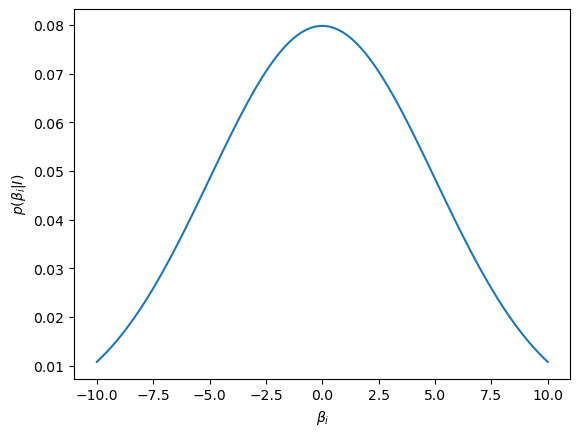

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def normal_distribution(mu,sigma2):
    return norm(loc=mu,scale=np.sqrt(sigma2))

betai = np.linspace(-10,10,100)
prior = normal_distribution(0,5.0**2)

fig, ax = plt.subplots(1,1)
ax.plot(betai,prior.pdf(betai))
ax.set_ylabel(r'$p(\beta_i \vert I )$')
ax.set_xlabel(r'$\beta_i$');

It is straightforward to evaluate Eq. {eq}`eq:BayesianLinearRegression:posterior_pars_with_iid_gaussian_prior`, which gives us

$$
\tildecovparsLR^{-1} &=  4 \begin{pmatrix} 2.01 & -1.0 \\ -1.0 & 5.01 \end{pmatrix} \\
\tilde{\parsLR} &= ( 0.992, 1.994)
$$ (eq_warmup_results)

This should be compared with the parameter vector $(1,2)$ we recovered using ordinary linear regression. With Bayesian linear regression we start from an informative prior with both parameters centered on zero with a rather large variance.

```{exercise} Warm-up Bayesian linear regression
:label: exercise:BayesianLinearRegression:warmup

Reproduce the posterior mean and covariance matrix from Eq. {eq}`eq_warmup_results`. You can use `numpy` methods to perform the linear algebra operations.
```

We can plot the posterior probability distribution for $\pars$, i.e., by plotting the bi-variate $\mathcal{N}-$distribution with the parameter in Eq. {eq}`eq_warmup_results`.

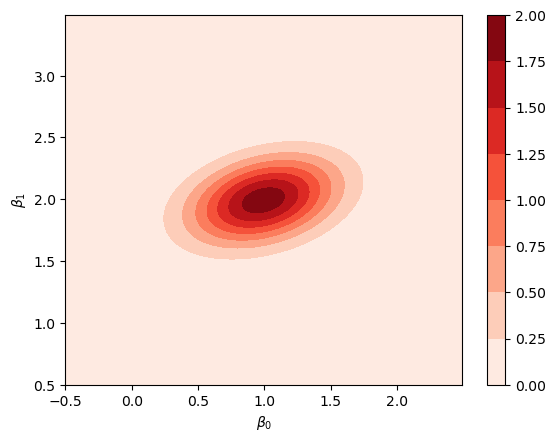

In [2]:
from scipy.stats import multivariate_normal

mu = np.array([0.992,1.992])
Sigma = np.linalg.inv(4 * np.array([[2.01,-1.0],[-1.0,5.01]]))

posterior = multivariate_normal(mean=mu, cov=Sigma)

beta0, beta1 = np.mgrid[-0.5:2.5:.01, 0.5:3.5:.01]
beta_grid = np.dstack((beta0, beta1))

fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'$\beta_0$')
ax.set_ylabel(r'$\beta_1$')
im = ax.contourf(beta0, beta1, posterior.pdf(beta_grid),cmap=plt.cm.Reds);
fig.colorbar(im);

Using Eq. {eq}`eq_marginal_N` we can obtain, e.g., the $\paraLR_1$ marginal density and compare with the prior

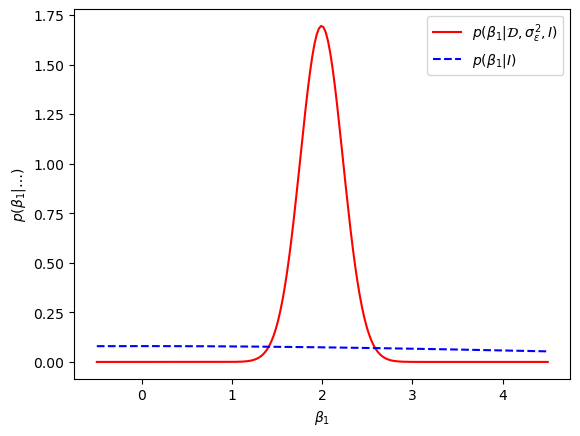

In [3]:
beta1 = np.linspace(-0.5,4.5,200)
mu1 = mu[1]
Sigma11_sq = Sigma[1,1]

posterior1 = normal_distribution(mu1,Sigma11_sq)

fig, ax = plt.subplots(1,1)
ax.plot(beta1,posterior1.pdf(beta1),'r-',\
label=r'$p(\beta_1 \vert \mathcal{D}, \sigma_\epsilon^2, I )$')
ax.plot(beta1,prior.pdf(beta1), 'b--',label=r'$p(\beta_1 \vert I )$')
ax.set_ylabel(r'$p(\beta_1 \vert \ldots )$')
ax.set_xlabel(r'$\beta_1$')
ax.legend(loc='best');

The key take-away with this numerical exercise is that Bayesian inference yields a probability distribution for the model parameters whose values we are uncertain about. With ordinary linear regression techniques you only obtain the parameter values that optimize some cost function, and not a probability distribution. 

```{exercise} Warm-up Bayesian linear regression (data errors)
:label: exercise:BayesianLinearRegression:warmup_errors

Explore the sensitivity to changes in the residual errors $\sigmares$. Try to increase and reduce the error.
```

```{exercise} Warm-up Bayesian linear regression (prior sensitivity)
:label: exercise:BayesianLinearRegression:warmup_priors

Explore the sensitivity to changes in the Gaussian prior width $\sigma_\paraLR$. Try to increase and reduce the width.
```

```{exercise} "In practice" Bayesian linear regression 
:label: exercise:BayesianLinearRegression:in_practice

Perform Bayesian Linear Regression on the data that was generated in [](sec:ols_in_practice_b). Explore:
- Dependence on the quality of the data (generate data with different $\sigma_\epsilon$) or the number of data.
- Dependence on the polynomial function that was used to generate the data.
- Dependence on the number of polynomial terms in the model.
- Dependence on the parameter prior.

In all cases you should compare the Bayesian inference with the results from Ordinary Least Squares and with the true parameters that were used to generate the data.
```


### Solutions to selected exercises


```{solution} exercise:BayesianLinearRegression:likelihood_pars
:label: solution:BayesianLinearRegression:likelihood_pars
:class: dropdown

- The likelihood can be written $\pdf{\data}{\parsLR,I} = \exp\left[ -L(\parsLR) \right]$, where we include information on the error distribution ($\sigmares$) in the conditional $I$. The negative log-likelihood, including the normalization factor, is

$$
L(\parsLR) = \frac{N_d}{2}\log(2\pi\sigmares^2) + \frac{1}{2\sigmares^2} \sum_{i=0}^{N_d - 1} (\data_i - (\dmat \parsLR)_i)^2.
$$

- Comparing with Eq. {eq}`eq:BayesianLinearRegression:cost-function` and the corresponding gradient vector {eq}`eq:BayesianLinearRegression:gradient` we find that

  $$
  \nabla_{\pars} L(\parsLR) = -\frac{\dmat^T\left( \data-\dmat\pars\right)}{\sigmares^2},
  $$

  which is zero at $\pars = \optparsLR = \left(\dmat^T\dmat\right)^{-1}\dmat^T\data$ corresponding to the solution of the normal equation.

- We can Taylor expand $L(\parsLR)$ around $\parsLR=\optparsLR$ realizing that the linear (gradient) term is zero. Furthermore, the quadrating term depends on the second derivative (hessian) which is a constant matrix since $L$ only depends quadratically on the parameters

$$
H = \Delta L = \nabla_{\parsLR} \cdot (\nabla_{\pars} L(\parsLR)) = \frac{\dmat^T\dmat}{\sigmares^2}
$$

- Since higher derivatives therefore must be zero, the Taylor expansion actually terminates at second order

$$
L(\parsLR) = L(\optparsLR) + \frac{1}{2} (\parsLR-\optparsLR)^T \frac{\dmat^T\dmat}{\sigmares^2} (\pars-\optparsLR)
$$

- We introduce $\covparsLR^{-1} \equiv {\dmat^T\dmat} / {\sigmares^2}$ and use that $\exp\left[ - L(\optparsLR) \right] = \pdf{\data}{\optparsLR,I}$. Therefore, evaluating $\exp\left[ -L(\parsLR) \right]$ gives

  $$
  \pdf{\data}{\parsLR,I} = \pdf{\data}{\optparsLR,I} \exp\left[ -\frac{1}{2} (\pars-\optparsLR)^T \covparsLR^{-1} (\pars-\optparsLR) \right],
  $$

  as we wanted to show.
```


````{solution} exercise:ols_example_1_b
:label: solution:ols_example_1_b
:class: dropdown

We have the following design matrix

$$
\dmat = \left[
    \begin{array}{cc}
        1 & -2 \\
        1 & 1
    \end{array}
\right],
$$

which in the present case yields the parameter values

$$
\pars^{*} = \dmat^{-1}\data = [1,2]^T.
$$
````


````{solution} exercise:ols_example_3_b
:label: solution:ols_example_3_b
:class: dropdown

For the warmup case we have fitted a straight line through two data points, which is always possible, and we cannot determine the sample variance. This will be even more clear when we come to [](sec:BayesianLinearRegression).

````


(sec:ols_in_practice_b)=
## Addendum: Ordinary linear regression in practice

We often have situation where we have much more than just two datapoints, and they rarely  fall exactly on a straight line. Let's use python to generate some more realistic, yet artificial, data. Using the function below you can generate data from some linear process with random variables for the underlying parameters. We call this a data-generating process.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def data_generating_process_reality(model_type, rng=np.random.default_rng(), **kwargs):
  if model_type == 'polynomial':
      true_params = rng.uniform(low=-5.0, high=5, size=(kwargs['poldeg']+1,))
      #polynomial model   
      def process(params, xdata):
          ydata = np.polynomial.polynomial.polyval(xdata,params)
          return ydata
      
  # use this to define a non-polynomial (possibly non-linear) data-generating process
  elif model_type == 'nonlinear':
      true_params = None
      def process(params, xdata):
          ydata = (0.5 + np.tan(np.pi*xdata))**2
          return ydata           
  else:
      print(f'Unknown Model')
      
  # return function for the true process the values for the true parameters
  # and the name of the model_type
  return process, true_params, model_type    

Next, we make some measurements of this process, and that typically entails some measurement errors. We will here assume that independently and identically distributed (i.i.d.) measurement errors $e_i$ that all follow a normal distribution with zero mean and variance $\sigma_e^2$. In a statistical notation we write $e_i \sim \mathcal{N}(0,\sigma_e^2)$. By default, we set $\sigma_e = 0.5$.

In [5]:
def data_generating_process_measurement(process, params, xdata, 
                           sigma_error=0.5, rng=np.random.default_rng()):
      
  ydata = process(params, xdata)
  
  #  sigma_error: measurement error. 
  error = rng.normal(0,sigma_error,len(xdata)).reshape(-1,1)

  return ydata+error, sigma_error*np.ones(len(xdata)).reshape(-1,)

Let us setup the data-generating process, in this case a linear process of polynomial degree 1, and decide how many measurements we make ($N_d=10$). All relevant output is stored in pandas dataframes.

In [6]:
#the number of data points to collect
# -----
Nd = 10
# -----

# predictor values
xmin = -1 ; xmax = +1
Xmeasurement = np.linspace(xmin,xmax,Nd).reshape(-1,1)
# store it in a pandas dataframe
pd_Xmeasurement = pd.DataFrame(Xmeasurement, columns=['x'])

# Define the data-generating process.
# Begin with a polynomial (poldeg=1) model_type
# in a second run of this notebook you can play with other linear models
reality, true_params, model_type = data_generating_process_reality(model_type='polynomial',poldeg=1)

print(f'model type      : {model_type}')
print(f'true parameters : {true_params}')
print(f'Nd = {Nd}')

# Collect measured data
# -----
sigma_e = 0.5
# -----
Ydata, Yerror = data_generating_process_measurement(reality,true_params,Xmeasurement,sigma_error=sigma_e)
# store the data in a pandas dataframe
pd_D=pd.DataFrame(Ydata,columns=['data'])
# 
pd_D['x'] = Xmeasurement
pd_D['e'] = Yerror

# We will also produce a denser grid for predictions with our model and comparison with the true process. This is useful for plotting
   
xreality = np.linspace(xmin,xmax,200).reshape(-1,1)
pd_R = pd.DataFrame(reality(true_params,xreality), columns=['data'])
pd_R['x'] = xreality

model type      : polynomial
true parameters : [-1.4992708   4.42772861]
Nd = 10


Create some analysis tool to inspect the data, and later on the model.

In [7]:
# helper function to plot data, reality, and model (pd_M)
def plot_data(pd_D, pd_R, pd_M, with_errorbars = True):
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.scatter(pd_D['x'],pd_D['data'],label=r'Data',color='black',zorder=1, alpha=0.9,s=70,marker="d");
    if with_errorbars:
        ax.errorbar(pd_D['x'],pd_D['data'], pd_D['e'],fmt='o', ms=0, color='black');
    if pd_R is not None:
        ax.plot(pd_R['x'], pd_R['data'],color='red', linestyle='--',lw=3,label='Reality',zorder=10)
    if pd_M is not None:
        ax.plot(pd_M['x'], pd_M['data'],color='blue', linestyle='--',lw=3,label='Model',zorder=11)
    ax.legend();
    ax.set_title('Collected data');
    ax.set_xlabel(r'Predictor $x$');
    ax.set_ylabel(r'Response $y$');
    return fig,ax

Let's have a look at the data. We set the last two arguments to `None` for visualizing only the data.

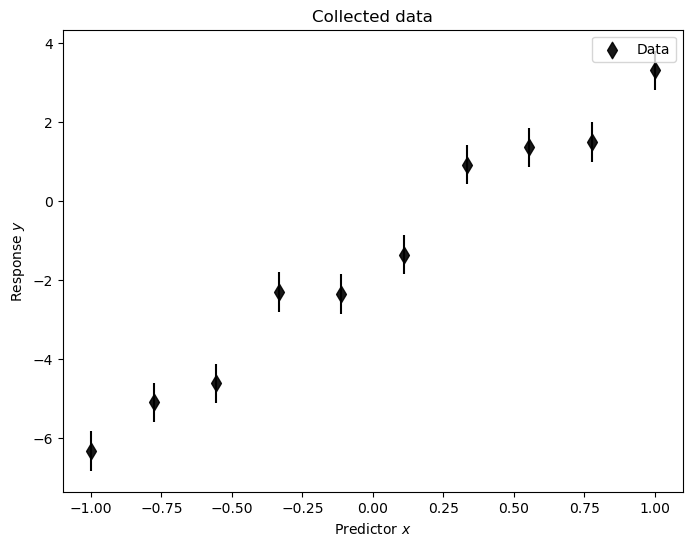

In [8]:
plot_data(pd_D, None, None);

Linear regression proceeds via the design matrix. We will analyze this data using a linear polynomial model of order 1. The following code will allow you to setup the corresponding design matrix $\dmat$ for any polynomial order (referred to as poldeg below)

In [9]:
def setup_polynomial_design_matrix(data_frame, poldeg, drop_constant=False, verbose=True):
    if verbose:
        print('setting up design matrix:')
        print('  len(data):', len(data_frame.index))

        # for polynomial models: x^0, x^1, x^2, ..., x^p
        # use numpy increasing vandermonde matrix
        print('  model poldeg:',poldeg)
    
    predictors = np.vander(data_frame['x'].to_numpy(), poldeg+1, increasing = True)
    if drop_constant:
        predictors = np.delete(predictors, 0, 1)
        if verbose:
            print('  dropping constant term')
    pd_design_matrix = pd.DataFrame(predictors)
        
    return pd_design_matrix

So, let's setup the design matrix for a model with polynomial basis functions. Note that there are $N_p$ parameters in a polynomial function of order $N_p-1$

$$
M(\parsLR;\inputt) = \paraLR_0 + \paraLR_1 \inputt.
$$

In [10]:
Np=2
pd_X = setup_polynomial_design_matrix(pd_Xmeasurement,poldeg=Np-1)

setting up design matrix:
  len(data): 10
  model poldeg: 1


We can now perform linear regression, or ordinary least squares (OLS), as

In [11]:
#ols estimator for physical parameter theta
D = pd_D['data'].to_numpy()
X = pd_X.to_numpy()

ols_cov   = np.linalg.inv(np.matmul(X.T,X))
ols_xTd   = np.matmul(X.T,D)
ols_theta = np.matmul(ols_cov,ols_xTd)

print(f'Ndata = {Nd}')
print(f'theta_ols \t{ols_theta}')
print(f'theta_true \t{true_params}\n')

Ndata = 10
theta_ols 	[-1.50349161  4.72284085]
theta_true 	[-1.4992708   4.42772861]



To evaluate the (fitted) model we setup a design matrix that spans dense values across the relevant range of predictors.

In [12]:
pd_Xreality = setup_polynomial_design_matrix(pd_R,poldeg=Np-1)

setting up design matrix:
  len(data): 200
  model poldeg: 1


and then we dot this with the fitted (ols) parameter values

In [13]:
Xreality = pd_Xreality.to_numpy()
pd_M_ols = pd.DataFrame(np.matmul(Xreality,ols_theta),columns=['data'])
pd_M_ols['x'] = xreality

A plot (which now includes the data-generating process 'reality') demonstrates the quality of the inference.

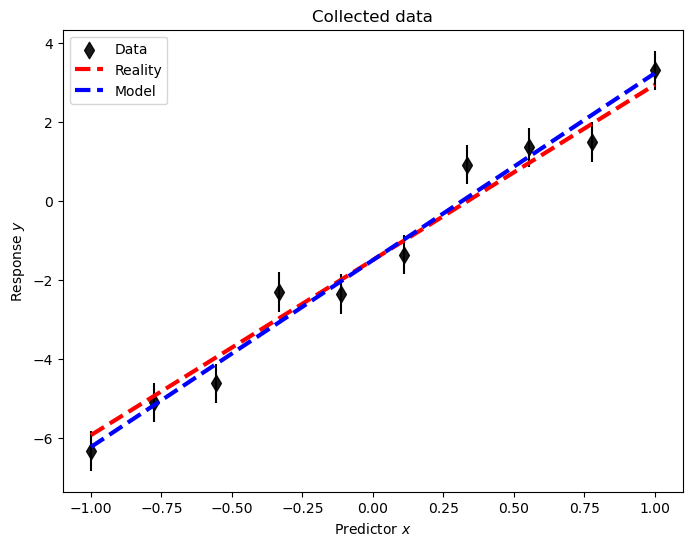

In [14]:
plot_data(pd_D, pd_R, pd_M_ols);

To conclude, we also compute the sample variance $s^2$

In [15]:
ols_D   = np.matmul(X,ols_theta)
ols_eps = (ols_D - D)
ols_s2 = (np.dot(ols_eps,ols_eps.T)/(Nd-Np))

print(f's^2       \t{ols_s2:.3f}')
print(f'sigma_e^2 \t{sigma_e**2:.3f}')

s^2       	0.292
sigma_e^2 	0.250


As seen, the extracted variance is in some agreement with the true one.

Using the code above, you should now try to do the following exercises.

```{exercise}
:label: exercise:ols_example_4_b
Keep working with the simple polynomial model $M = \paraLR_0 + \paraLR_1 x$

Reduce the number of data to 2, i.e., set Nd=2. Do you reproduce the result from the simple example in the previous section?

Increase the number of data to 1000. Do the OLS values of the model parameters and the sample variance approach the (true) parameters of the data-generating process? Is this to be expected? 
```

```{exercise}
:label: exercise:ols_example_5_b
Set the data-generating process to be a 3rd-order polynomial and set limits of the the predictor variable to [-3,3]. Analyze the data using a 2nd-order polynomial model.

Explore the limit of $N_d \rightarrow \infty$ by setting $N_d = 500$ or so. Will the OLS values of the model parameters and the sample variance approach the (true) values for some of the parameters? 
```